In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
#!unzip /content/gdrive/MyDrive/nature_12K.zip

In [6]:
!unzip /content/gdrive/MyDrive/nature_12K.zip > /dev/null

In [2]:
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os, random
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model

In [3]:
batch_size = 32
img_height = 180
img_width = 180
data_dir='/content/inaturalist_12K/train'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.


In [5]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 999 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


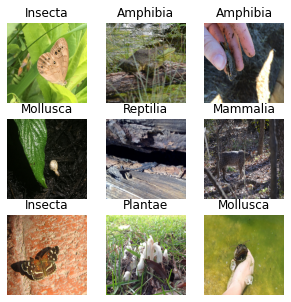

In [7]:
#first 9 images in training dataset
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

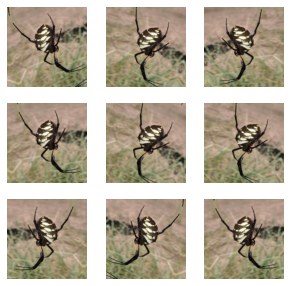

In [9]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  #print(image_batch.numpy())
  break

(32, 180, 180, 3)
(32,)


In [11]:
ag_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

ag_train_ds = ag_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 10
filter_no = [16,32,64,128,256]
kernel_size = [3,3,3,3,3]
act_function = ['relu','relu','relu','relu','relu']
dense_act='relu'
dense_neurons = 512

In [14]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.001, mode='max')

In [15]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(filter_no[0], kernel_size[0], activation=act_function[0],padding='same'),
  layers.BatchNormalization(),
  #layers.SpatialDropout2D(0.3),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(filter_no[1], kernel_size[1], activation=act_function[1],padding='same'),
  layers.BatchNormalization(),
  #layers.SpatialDropout2D(0.3),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(filter_no[2], kernel_size[2], activation=act_function[2],padding='same'),
  layers.BatchNormalization(),
  #layers.SpatialDropout2D(0.3),
  layers.MaxPooling2D(pool_size=(2, 2),strides=2),
  layers.Conv2D(filter_no[3], kernel_size[3], activation=act_function[3],padding='same'),
  layers.BatchNormalization(),
  #layers.SpatialDropout2D(0.3),
  layers.MaxPooling2D(pool_size=(2, 2),strides=2),
  layers.Conv2D(filter_no[4], kernel_size[4], activation=act_function[4],padding='same'),
  layers.BatchNormalization(),
  #layers.SpatialDropout2D(0.3),
  layers.MaxPooling2D(pool_size=(2, 2),strides=2),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(dense_neurons,kernel_regularizer='l2', activation=dense_act,kernel_initializer='GlorotUniform'),
  layers.Dense(num_classes,activation='softmax')
])

In [16]:
epoch=5
optimizer ='sgd'

In [17]:
model.compile(optimizer=optimizer,loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
history = model.fit(ag_train_ds,validation_data=valid_ds,epochs=epoch,callbacks=[early_stopping])

Epoch 1/5
282/282 [==============================] - 539s 2s/step - loss: 12.0182 - accuracy: 0.1971 - val_loss: 11.1690 - val_accuracy: 0.1782
Epoch 2/5
104/282 [==========>...................] - ETA: 4:54 - loss: 10.3618 - accuracy: 0.3006

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)       

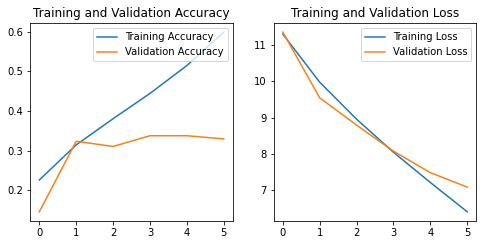

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
test_dir='/content/inaturalist_12K/val'

In [50]:
# Applying Best model on test Data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1,
  shuffle='False')

Found 2000 files belonging to 10 classes.


In [51]:
model.evaluate(test_ds,batch_size=1)

2000/2000 [==============================] - 97s 49ms/step - loss: 7.1283 - accuracy: 0.3015


[7.128283500671387, 0.30149999260902405]

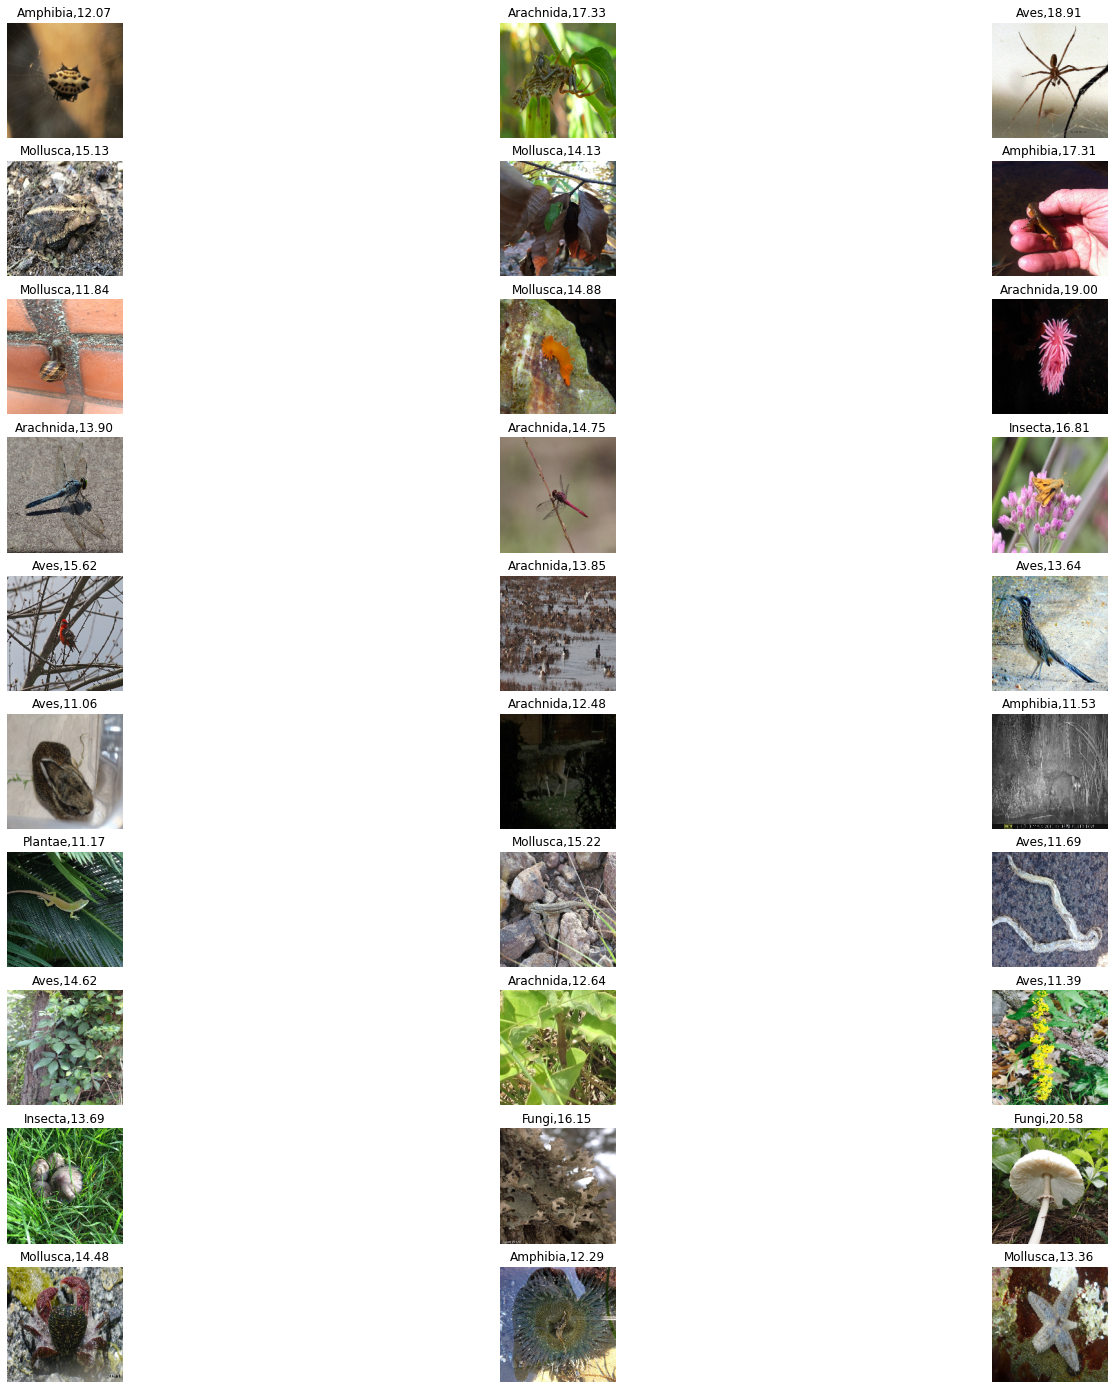

In [52]:
plt.figure(figsize=(25, 25))
index=1
for subdir in os.listdir(test_dir):
  files=[random.choice(os.listdir(os.path.join(test_dir, subdir))) for i in range(3)]
  for file in files:
    path=os.path.join(os.path.join(test_dir, subdir),file)
    #print(path)
    img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    plt.subplot(10,3,index)
    plt.imshow(img)
    plt.title("{},{:.2f}".format(class_names[np.argmax(score)], 100 * np.max(score)))
    plt.axis("off")
    index+=1

In [53]:
# summarize filter shapes
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_5 (3, 3, 3, 16)
conv2d_6 (3, 3, 16, 32)
conv2d_7 (3, 3, 32, 64)
conv2d_8 (3, 3, 64, 128)
conv2d_9 (3, 3, 128, 256)


In [54]:
rn_class = random.choice(os.listdir(test_dir))
rn_file = random.choice(os.listdir(os.path.join(test_dir, rn_class)))
rn_path = os.path.join(os.path.join(test_dir, rn_class),rn_file)
print(rn_path)

/content/inaturalist_12K/val/Amphibia/bc110a8ed2218070478cd72b2bbd04df.jpg


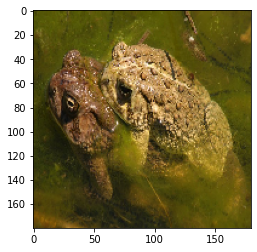

In [55]:
rn_image = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
plt.imshow(rn_image)

In [56]:
filters,biases=model.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filter_count=filters.shape[3]
no_of_filter=8
depth=filters.shape[2]
print(filter_count,depth)

16 3


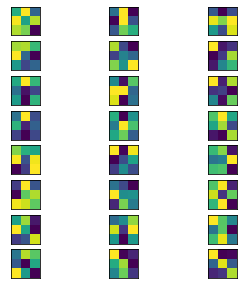

In [57]:
ind=1
plt.figure(figsize=(5, 5))
for id in range(no_of_filter):
  filt=filters[:,:,:,id]
  for i in range(depth):
    ax=plt.subplot(no_of_filter,depth,ind)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filt[:,:,i])
    ind+=1
plt.show()

In [58]:
img = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
visual_model=Model(inputs=model.input,outputs=model.layers[1].output)
visual_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1_input (InputLaye [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [59]:
feature_map=visual_model.predict(img_array)

In [60]:
print(feature_map.shape)

(1, 180, 180, 16)


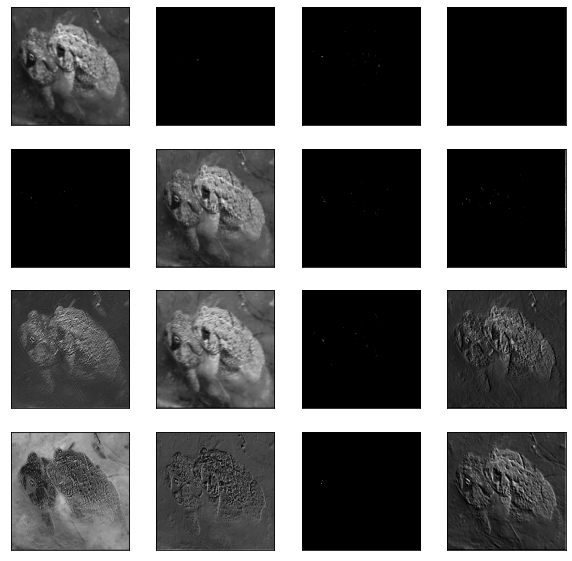

In [61]:
square=int(np.sqrt(filter_count))
index=1
plt.figure(figsize=(10, 10))
for i in range(square):
  for j in range(square):
    ax=plt.subplot(square,square,index)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0,:,:,index-1],cmap='gray')
    index += 1
plt.show()

In [115]:
model.layers[13].name

'conv2d_9'

In [ ]:
layer_output = model.layers[13].output
f5=random.choice(range(layer_output.shape[3]))
layer_output[0,:,:,f5]

In [113]:
grad=K.gradients(output,model.trainable_weights[12])

TypeError: ignored